In [118]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import datasets, transforms

from utils import Logger
from IPython import display

# Dataset
# Network
# Optimizer and Loss
# Training

# 1.Dataset
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    data_folder = './torch_data/VGAN/mnist'
    out_dir = "{}/dataset".format(data_folder)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [119]:
# 2.Network

# Discriminator
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.layer0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        
        return x

# Generator
class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.layer0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.layer1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)

        return x

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

# Noise
def noise(size):
    return Variable(torch.randn(size, 100)).cuda()

discriminator = DiscriminatorNet().cuda()
generator = GeneratorNet().cuda()

In [120]:
# 3. Optimizer
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)

loss = nn.BCELoss()

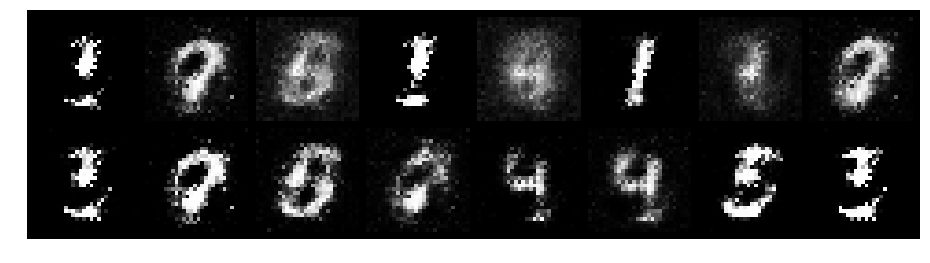

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.3990, Generator Loss: 2.1182
D(x): 0.9288, D(G(z)): 0.1963


In [ ]:
# 4. Training
d_steps = 1
num_epoches = 200

def real_data_target(size):
    return Variable(torch.ones(size, 1)).cuda()

def fake_data_target(size):
    return Variable(torch.zeros(size, 1)).cuda()

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 4.1 Train on real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()
    
    # 4.2 Train on fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, real_data_target(fake_data.size(0)))
    error_fake.backward()
    
    optimizer.step()
    
    return error_fake

# Generate Samples for Testing
num_test_samples = 16
test_noise = noise(num_test_samples)

# logger
logger = Logger(model_name="VGAN", data_name='MNIST')

# Start training
for epoch in range(num_epoches):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch)).cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
        
        # 2. Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
   
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
            # Display status logs
            logger.display_status(
                epoch, num_epoches, n_batch, num_batches, 
                d_error, g_error, d_pred_real, d_pred_fake
            )
            logger.save_models(generator, discriminator, epoch)
